# <span style='background:Yellow'> Bottom Temp & Salt difference between SOSE and WOA

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.447ce3e12d994d58b3a30fbae4228f24/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas
import scipy
import xesmf as xe

In [4]:
def open_ds(path, filename):    
    return xr.open_dataset(path+filename, decode_times=False)

woa_path = '/home/jovyan/chapter1/WOA/'
sose_path = '/home/jovyan/chapter1/SOSE-budgets/'

woa0512_pt1 = open_ds(woa_path,'pt_bottom_wg_0512.nc')
woa0512_pt_error1 = open_ds(woa_path, 'pt_bottom_error_0512.nc')
woa0512_slt1 = open_ds(woa_path, 'san_bottom_wg_0512.nc')
woa0512_slt_error1 = open_ds(woa_path, 'san_bottom_error_0512.nc')

sose_temp = open_ds(sose_path, 'bottom_temp.nc')
sose_std_temp = open_ds(sose_path, 'bottom_std_temp.nc')
sose_slt = open_ds(sose_path, 'bottom_salt.nc')
sose_std_slt = open_ds(sose_path, 'bottom_std_salt.nc')

depth = open_ds(sose_path, 'depth.nc')
surface_mask = open_ds(sose_path, 'surface_mask.nc')

In [5]:
#slicing lat to be 57.5˚S so it's closer to SOSE's boundaries
woa0512_pt = woa0512_pt1.isel(lat=slice(None, -5))
woa0512_pt_error = woa0512_pt_error1.isel(lat=slice(None, -5))
woa0512_slt = woa0512_slt1.isel(lat=slice(None, -5))
woa0512_slt_error = woa0512_slt_error1.isel(lat=slice(None, -5))

# <span style='background:Pink'> <font color='Red'> Temperature </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto SOSE's finer grid

In [6]:
regridder = xe.Regridder(woa0512_pt, sose_temp.THETA, method='bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_23x96_125x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (23, 96) 
Output grid shape:          (125, 570) 
Periodic in longitude?      False

In [7]:
woa0512_pt_new_grid = regridder(woa0512_pt)
woa0512_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, YC: 125, XC: 570)
Coordinates:
  * time     (time) float32 6.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
Data variables:
    PT       (time, YC, XC) float64 0.0 0.0 0.0 nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto SOSE's grid

In [8]:
regridder_0512_error = xe.Regridder(woa0512_pt_error, sose_temp, method='bilinear')

woa0512_pt_error_new_grid = regridder(woa0512_pt_error)
woa0512_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, YC: 125, XC: 570)
Coordinates:
  * time      (time) float32 6.0
  * YC        (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    lat       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * XC        (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lon       (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
Data variables:
    PT_error  (time, YC, XC) float64 0.0 0.0 0.0 nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (1981-2012) </font>

In [9]:
sose_woa0512_diff = sose_temp.THETA - woa0512_pt_new_grid.isel(time=0).PT
sose_woa0512_diff

<xarray.DataArray (YC: 125, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [ 3.77803493,  3.7657063 ,  3.76473594, ..., -0.07098768,
        -0.05914604, -0.04898664],
       [ 3.82085729,  3.80381846,  3.80637527, ...,  0.40603539,
         0.4132565 ,  0.42193878],
       [ 3.83108616,  3.80568409,  3.80619192, ...,  0.4620544 ,
         0.46563441,  0.47200996]])
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
    time     float32 6.0

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Difference between \n SOSE (2005-2010) and WOA (1981-2010)')

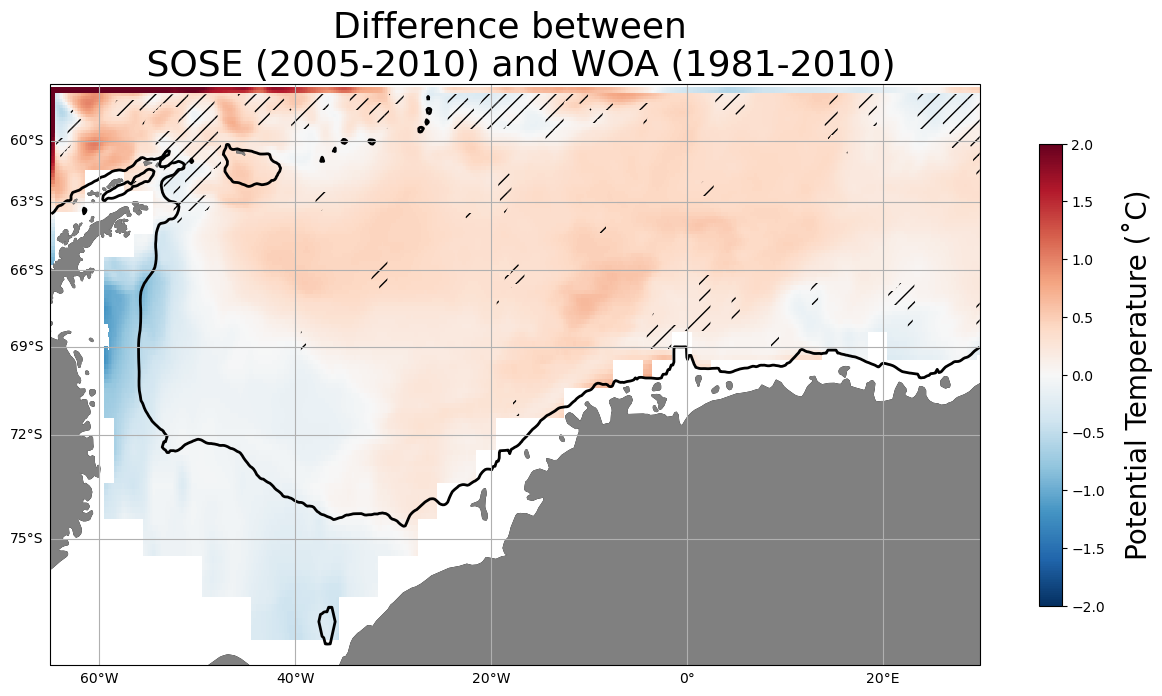

In [10]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(depth.lon, depth.YC, depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(sose_woa0512_diff.lon, 
                   sose_woa0512_diff.lat, 
                   sose_woa0512_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(sose_woa0512_diff.lon, 
             sose_woa0512_diff.lat,  
             sose_woa0512_diff.where(np.abs(sose_woa0512_diff) < woa0512_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=26)
#plt.savefig('bot-temp-soseWoa8110-1km-isobath.pdf');

In [11]:
regridder_2 = xe.Regridder(woa0517_pt, sose_temp, method='bilinear')
regridder_2

NameError: name 'woa0517_pt' is not defined

In [ ]:
woa0517_pt_new_grid = regridder_2(woa0517_pt)
woa0517_pt_new_grid

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_pt_new_grid.lon, 
                   woa0517_pt_new_grid.lat, 
                   woa0517_pt_new_grid.PT[0].where(surface_mask_sose.hFacC), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto SOSE's grid", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (2005-2012) salt data onto SOSE's grid

In [14]:
regridder_slt = xe.Regridder(woa0512_slt, sose_slt.SALT, method='bilinear')

woa0512_slt_new_grid = regridder_slt(woa0512_slt)
woa0512_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, YC: 125, XC: 570)
Coordinates:
  * time     (time) float32 6.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
Data variables:
    s_an     (time, YC, XC) float32 0.0 0.0 0.0 nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2012) salt ERROR data onto SOSE's grid

In [17]:
regridder_slt_error = xe.Regridder(woa0512_slt_error, sose_slt, method='bilinear')

woa0512_slt_error_new_grid = regridder_slt_error(woa0512_slt_error)
woa0512_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, YC: 125, XC: 570)
Coordinates:
  * time     (time) float32 6.0
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    Z        (YC, XC) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Data variables:
    s_se     (time, YC, XC) float32 0.0 0.0 0.0 nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SOSE - WOA` (2005-2012) </font>

In [18]:
sose_woa0512_slt_diff = sose_slt.SALT - woa0512_slt_new_grid.isel(time=0).s_an
sose_woa0512_slt_diff

<xarray.DataArray (YC: 125, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [33.955868  , 33.95334   , 33.95196   , ..., -0.7503357 ,
        -0.747612  , -0.74570084],
       [33.95569   , 33.953175  , 33.952255  , ..., 33.91891   ,
        33.91983   , 33.920223  ],
       [33.955345  , 33.952297  , 33.9507    , ..., 33.933758  ,
        33.933937  , 33.933216  ]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    Z        (YC, XC) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
    time     float32 6.0

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Difference between \n SOSE (2005-2010) and WOA (1981-2010)')

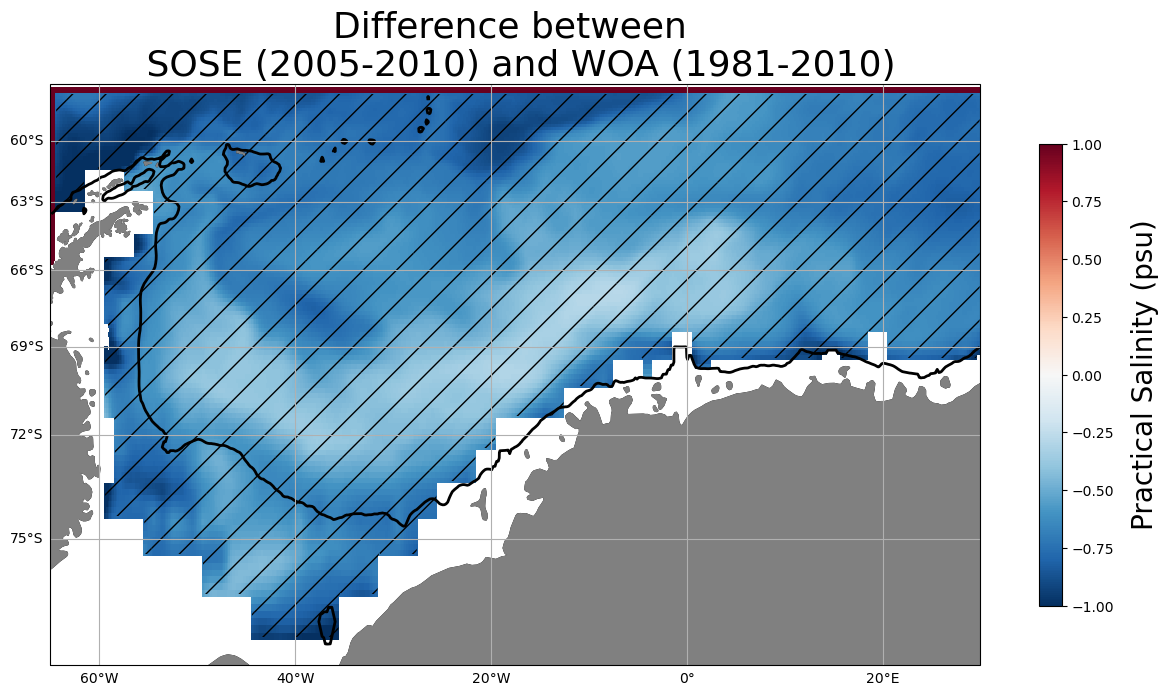

In [22]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(depth.lon, depth.YC, depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(sose_woa0512_slt_diff.lon, 
                   sose_woa0512_diff.lat, 
                   sose_woa0512_slt_diff.where(surface_mask.hFacC),
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

plt.contourf(sose_woa0512_slt_diff.lon, 
             sose_woa0512_diff.lat, 
             sose_woa0512_slt_diff.where(np.abs(sose_woa0512_slt_diff) < woa0512_slt_new_grid.s_an[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=26)
#plt.savefig('bot-salt-soseWoa8110-1km-isobath.pdf');